# Example: Predicting individual traits from an HMM

This tutorial goes through two different ways of predicting or classifying individual traits from an HMM: the Fisher kernel and the summary metrics approach. 

The Fisher kernel (Jaakkola & Haussler, 1998) is a mathematically principled approach that uses the entire set (or a selection) of HMM parameters and constructs from them a kernel, representing between-subject similarities. This kernel can be used in a straightforward and computationally efficient way in any kernel-based prediction or classifier. The approach has been shown to be more accurate and reliable than other methods (Ahrends, Woolrich, & Vidaurre (preprint, 2023): https://www.biorxiv.org/content/10.1101/2023.03.02.530638v2). Alternatively, you can predict individual traits from summary metrics, using the same features that can be used for statistical testing.

We demonstrate and compare the two approaches on the HCP S1200 Young Adult dataset (van Essen et al., 2013: https://pubmed.ncbi.nlm.nih.gov/23684880/) to predict age and cognitive variables from brain dynamics at rest. The data are available at https://db.humanconnectome.org/. For reproducibility and since the dataset is very large, we provide a pretrained HMM. Alternatively, you can train the HMM on the dataset using stochastic inference. 

## Load and prepare data: 
This requires that the following files are available:
* data: HCP rest fMRI timeseries from 1001 subjects in groupICA50 parcellation
* behav: behavioural/demographic items from 1001 HCP subjects
* T_t: indices for beginning and start of each subject's scanning session
* twins: matrix indicating family structure (subjects x subjects), zeros for unrelated subjects and positive values for related subjects (diagonal will be ignored)
* confounds: confounding variables for 1001 subjects (here sex and head motion)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from glhmm import glhmm, preproc, prediction

In [2]:
# load data from csv files
data_tmp = pd.read_csv('tc1001_RESTall_groupICA50.csv', header=None)
T_t_tmp = pd.read_csv('T.csv', header=None)
behav_tmp = pd.read_csv('behav1001_35var.csv', header=None)
twins_tmp = pd.read_csv('twins.csv', header=None)
confounds_tmp = pd.read_csv('confounds.csv', header=None)

# convert to numpy arrays
data = data_tmp.to_numpy()
behav = behav_tmp.to_numpy()
T_t = T_t_tmp.to_numpy()
twins = twins_tmp.to_numpy()
confounds = confounds_tmp.to_numpy()
del data_tmp, behav_tmp, T_t_tmp, twins_tmp, confounds_tmp

# check that dimensions of input files are correct:
# data should be (n_subjects*n_timepoints, n_parcels)
# behav should be (n_subjects, n_variables)
# T_t should be (n_subjects, 2)
# twins should be (n_subjects, n_subjects)
# confounds should be (n_subjects, n_confounds) or (n_subjects,)
print(data.shape)
print(behav.shape)
print(T_t.shape)
print(twins.shape)
print(confounds.shape)

(4804800, 50)
(1001, 35)
(1001, 2)
(1001, 1001)
(1001, 2)


Standardise timeseries for all following computations. This is an important step, especially when looking at differences between individuals, to make sure that predictions are not driven by measurement noise.

In [3]:
data_preproc,_ = preproc.preprocess_data(data, T_t)

Plot the difference between the original and the standardised timeseries:

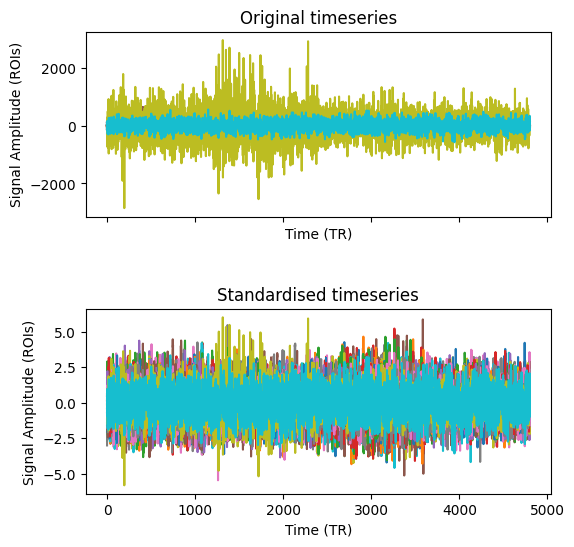

In [4]:
# for one example subject
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(data[0:4800,:])
ax0.set_xlabel("Time (TR)")
ax0.set_ylabel("Signal Amplitude (ROIs)")
ax0.title.set_text("Original timeseries")
ax1.plot(data_preproc[0:4800,:])
ax1.set_xlabel("Time (TR)")
ax1.set_ylabel("Signal Amplitude (ROIs)")
ax1.title.set_text("Standardised timeseries")
plt.subplots_adjust(hspace=0.5)
plt.show()

In [5]:
# delete non-standardised data to save memory
del data

## Load or train HMM and check parameter estimates

Load the pre-trained HMM, provided in example folder, or train HMM on standardised timeseries using stochastic inference. Here, we have trained the HMM using a Gaussian observation model with mean and covariance for 6 states.

In [6]:
with open('hmm_hcp_preproc.pkl', 'rb') as inp:
    hmm = pickle.load(inp)

check HMM parameter estimates:

In [7]:
K = hmm.hyperparameters["K"] # the number of states
q = data_preproc.shape[1] # the number of parcels/channels
init_stateP = hmm.Pi # the initial state probabilities
TP = np.zeros(shape=(K, K))
TP = hmm.P # the transition probability matrix
state_means = np.zeros(shape=(q, K))
state_means = hmm.get_means() # the state means in the shape (no. features, no. states)
state_FC = np.zeros(shape=(q, q, K))
for k in range(K):
    state_FC[:,:,k] = hmm.get_covariance_matrix(k=k) # the state covariance matrices in the shape (no. features, no. features, no. states)

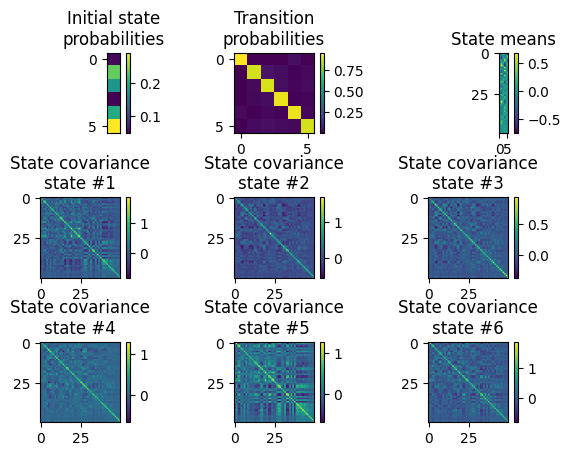

In [8]:
# plot initial state probabilities:
plt.subplot(3,3,1)
plt.imshow(init_stateP.reshape(-1, 1))
plt.title("Initial state\nprobabilities")
plt.xticks(())
plt.colorbar()
# plot transition probabilities:
plt.subplot(3,3,2)
plt.imshow(TP)
plt.title("Transition\nprobabilities")
plt.colorbar()
# plot state means:
plt.subplot(3,3,3)
plt.imshow(state_means)
plt.colorbar()
plt.title("State means")
# plot state covariances:
for k in range(6):
    plt.subplot(3,3,4+k)
    plt.imshow(state_FC[:,:,k])
    plt.colorbar()
    plt.title("State covariance\nstate #%s" % (k+1))
plt.subplots_adjust(hspace=0.8, wspace = 0.8)
plt.show()

## Predicting from HMMs

To predict from an HMM, you can use the function `predict_phenotype` from the prediction module. This function goes through the following steps:
1. create the Fisher kernel or extract summary metrics from a group-level HMM
2. fit prediction model:

    using nested cross-validation, where the inner CV loops are used to optimise hyperparameters via grid search
        
    (optionally) deconfounding during CV
        
    (optionally) accounting for group/family structure so that related subjects are never split across folds
3. predict on test set
4. evaluate predictive performance

The function uses as input a pretrained HMM (`hmm`), the neuroimaging timeseries of a group of subjects (`Y`), the variable/phenotype from the same group of subjects that you want to predict (`behav`), as well as indices specifying the start and end of each individual in the timeseries (`indices`). It returns the model-predicted values for the variable, the correlation coefficient between the model-predicted and the actual values, and other optional output if requested. The approach (Fisher kernel or summary metrics) is specified using the `predictor` argument. The estimator can also be provided using the `estimator` argument and will otherwise default to kernel ridge regression when using the Fisher kernel approach and to ridge regression when using the summary metrics approach. All other relevant options can be specified by providing a dictionary for the `options` argument. 

`predict_phenotype` uses (kernel) ridge regression for prediction. The estimator, as well as all other steps can be customised as detailed under **"Customising HMM prediction pipeline"**.

We will now demonstrate two approaches to predicting individual traits from an HMM using this function: the Fisher kernel (default), and the summary metrics approach.

### Option 1: Fisher kernel
The Fisher kernel allows using either all or a selection of HMM parameters for a prediction/classification, and it is constructed from the HMM in a mathematically principled manner that preserves the underlying structure of the model parameters. This approach is recommended because it tends to predict more accurately and does so more robustly than other methods (see Ahrends, Woolrich, & Vidaurre (preprint, 2023) for details).

In [9]:
np.random.seed(0)

In [10]:
options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# when not using group/family structure, simply don't specify this option
options['confounds'] = confounds # confounding variables (here sex and head motion)
# when not using confounds, simply don't specify this option
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
# Fisher kernel options:
options['shape'] = 'linear'
options['incl_Mu'] = True # include state means
options['incl_Sigma'] = True # include state covariances
# the initial state probabilities and the transition probabilities
# are used by default, but can be excluded by setting options['incl_Pi']
# and options['incl_P'], respectively, to False

# use HMM trained/loaded above and standardised timeseries to predict subjects' age:
age = behav[:,0]
results = prediction.predict_phenotype(hmm, data_preproc, age, T_t, predictor='Fisherkernel', estimator='KernelRidge', options=options)


`results` contains the out-of-sample predictions for age (both in deconfounded and original space) and the correlation between the model-predicted and the actual ages of subjects (`corr`). Additionally, we have here requested the output to also contain the coefficients of determination (`scores`), the estimated hyperparameters of each fold - in this case the regularisation parameters alpha (`hyperparams`), and the trained models themselves (`models`).

In [11]:
print(results['corr_deconf']) # the correlation coefficient
print(results['scores_deconf']) # the coefficients of determination
print(results['hyperparams']) # the regularisation parameters
results['models'][0] # the first estimated model

0.36261482897028813
[-40.60263474160619, -51.749974876195246, -57.7723165438615, -44.261108199195576, -51.87452391727416, -53.83469712607069, -59.6654517846152, -65.3707381217127, -60.86722871902594, -53.869191934751385]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


GridSearchCV(cv=GroupKFold(n_splits=10),
             estimator=KernelRidge(kernel='precomputed'),
             param_grid={'alpha': array([0.0001    , 0.00039811, 0.00158489, 0.00630957, 0.02511886,
       0.1       ])})

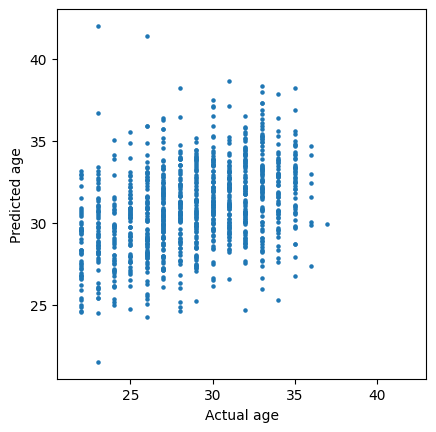

In [180]:
plt.scatter(age, results['behav_predD'], s=5, color='tab:blue')
minval = min((min(age), min(results['behav_predD'])))
maxval = max((max(age), max(results['behav_predD'])))
plt.xlim((minval-1),(maxval+1))
plt.ylim((minval-1),(maxval+1))
plt.gca().set_xlabel('Actual age')
plt.gca().set_ylabel('Predicted age')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Option 2: Summary metrics

The second option is to extract summary metrics from a trained HMM and use these as features for a prediction. Which metrics to include should be specified in `options['metrics']`. At the moment, possible summary metrics include state fractional occupancies (`'FO'`), lifetimes (`'lifetimes'`), and switching rates (`'switching_rate'`). 

In [13]:
options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# when not using group/family structure, simply don't specify this option
options['confounds'] = confounds # confounding variables (here sex and head motion)
# when not using confounds, simply don't specify this option
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
# summary metrics options:
options['metrics'] = ('FO', 'lifetimes', 'switching_rate')
# include the fractional occupancies (FO), the state lifetimes, and the switching rates

# use HMM trained/loaded above and standardised timeseries to predict subjects' age:
age = behav[:,0]
results2 = prediction.predict_phenotype(hmm, data_preproc, age, T_t, predictor='summary_metrics', estimator='Ridge', options=options)


In [14]:
print(results2['corr_deconf'])
print(results2['scores_deconf'])
print(results2['hyperparams'])
results2['models'][0]

0.07824252756270551
[-47.839551164333045, -60.017530687129835, -67.39107073016814, -52.4784756934237, -60.32428365298793, -63.205603105070864, -70.53091268079955, -75.5279227430322, -71.16351272633247, -63.50354233701292]
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


GridSearchCV(cv=GroupKFold(n_splits=10), estimator=Ridge(),
             param_grid={'alpha': array([0.0001    , 0.00039811, 0.00158489, 0.00630957, 0.02511886,
       0.1       ])})

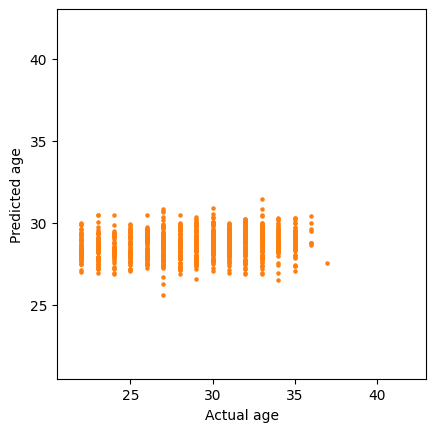

In [179]:
plt.scatter(age, results2['behav_predD'], s=5, color='tab:orange')
minval = min((min(age), min(results['behav_predD'])))
maxval = max((max(age), max(results['behav_predD'])))
plt.xlim((minval-1),(maxval+1))
plt.ylim((minval-1),(maxval+1))
plt.gca().set_xlabel('Actual age')
plt.gca().set_ylabel('Predicted age')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Comparing the two approaches: Predicting cognitive traits in HCP data

We can see that to predict age, the Fisher kernel approach produces a more accurate prediction. Run both approaches to predict a range of behavioural items and compare their accuracies. NOTE: This will take a while to run. The results are also provided in the example folder.

In [15]:
options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
options['confounds'] = confounds # confounding variables (here sex and head motion)

results_FK = list()
results_summ = list()
for i in range(35):
    trait = behav[:,i]
    # predict using Fisher kernel
    options['shape'] = 'linear'
    options['incl_Mu'] = True # include state means
    options['incl_Sigma'] = True # include state covariances
    results_tmp = prediction.predict_phenotype(hmm, data_preproc, trait, T_t, predictor='Fisherkernel', estimator='KernelRidge', options=options)
    results_FK.append(results_tmp['corr_deconf'])
    options.pop('shape')
    options.pop('incl_Mu')
    options.pop('incl_Sigma')
    # predict using summary metrics
    options['metrics'] = ('FO', 'lifetimes', 'switching_rate')
    results_tmp = prediction.predict_phenotype(hmm, data_preproc, trait, T_t, predictor='summary_metrics', estimator='Ridge', options=options)
    results_summ.append(results_tmp['corr_deconf'])
    options.pop('metrics')

In [76]:
import pickle
with open('resultsFK_hcp_pred.pkl', 'wb') as outp:
    pickle.dump(results_FK, outp, pickle.HIGHEST_PROTOCOL)

with open('resultssumm_hcp_pred.pkl', 'wb') as outp:
    pickle.dump(results_summ, outp, pickle.HIGHEST_PROTOCOL)

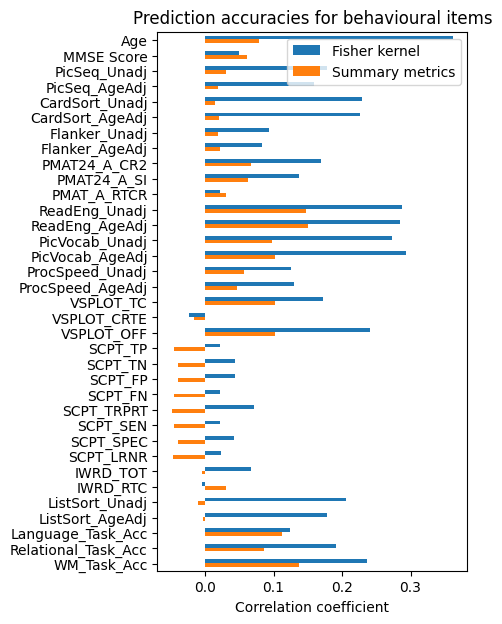

In [87]:
variables = ("Age", "MMSE Score", "PicSeq_Unadj", "PicSeq_AgeAdj",
             "CardSort_Unadj", "CardSort_AgeAdj", "Flanker_Unadj",
             "Flanker_AgeAdj", "PMAT24_A_CR2", "PMAT24_A_SI", 
             "PMAT_A_RTCR", "ReadEng_Unadj", "ReadEng_AgeAdj",
             "PicVocab_Unadj", "PicVocab_AgeAdj", "ProcSpeed_Unadj",
             "ProcSpeed_AgeAdj", "VSPLOT_TC", "VSPLOT_CRTE", 
             "VSPLOT_OFF", "SCPT_TP", "SCPT_TN", "SCPT_FP", "SCPT_FN",
             "SCPT_TRPRT", "SCPT_SEN", "SCPT_SPEC", "SCPT_LRNR", 
             "IWRD_TOT", "IWRD_RTC", "ListSort_Unadj", "ListSort_AgeAdj",
             "Language_Task_Acc", "Relational_Task_Acc", "WM_Task_Acc")
comp_acc = {
    'Fisher kernel': results_FK,
    'Summary metrics': results_summ
}
acc_df = pd.DataFrame(comp_acc, index=variables)
x = np.arange(behav.shape[1])
width = 0.3

ax = acc_df.plot.barh(figsize=(4,7),
    rot=0, color={"Fisher kernel": "tab:blue", "Summary metrics": "tab:orange"}, align="edge")
ax.invert_yaxis()
ax.set_xlabel('Correlation coefficient')
ax.set_title('Prediction accuracies for behavioural items')
ax.legend(loc='upper right', ncols=1)
ax.set_yticks(x + width, variables)

plt.show()

### Classifying from an HMM

Analogous to `predict_phenotype`, the function `classify_phenotype` allows classifying from an HMM. As an example, we can classify sex (which was used as a confound in the predictions above) in the HCP data. We will first classify using the Fisher kernel method:

In [16]:
sex = confounds[:,0]

In [17]:
options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
options['return_prob'] = True # for classification, you can optionally also return the probabilities for each class, but note that this will take longer
# Fisher kernel options:
options['shape'] = 'linear'
options['incl_Mu'] = True # include state means
options['incl_Sigma'] = True # include state covariances

# use HMM trained/loaded above and standardised timeseries to classify sex using Fisher kernel method:
classif_FK = prediction.classify_phenotype(hmm, data_preproc, sex, T_t, predictor='Fisherkernel', estimator='SVM', options=options)

In [18]:
print(classif_FK['acc'])

0.8981018981018981


The Fisher kernel can thus classify sex at close to 90% accuracy.

Like in `predict_phenotype`, we can also classify based on summary features by setting the `predictor` argument to `summary_metrics`:

In [ ]:
options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
options['return_prob'] = True # for classification, you can optionally also return the probabilities for each class, but note that this will take longer
# summary metrics options:
options['metrics'] = ('FO', 'lifetimes', 'switching_rate')

# use HMM trained/loaded above and standardised timeseries to classify sex from summary metrics:
classif_summ = prediction.classify_phenotype(hmm, data_preproc, sex, T_t, predictor='summary_metrics', estimator='LogisticRegression', options=options)

In [20]:
print(classif_summ['acc'])

0.6233766233766234


The classification accuracy of the summary metrics approach is around 62%.

As a sanity check, we can try predicting a random binary array from the function using the Fisher kernel and make sure that predictions are at chance level:

In [21]:
options = {}
# general options:
options['nfolds'] = 10 # number of folds for inner & outer CV loops
options['group_structure'] = twins # group structure that CV should take into account, in this case the family relations. This option makes sure that related subjects are never split across CV folds
# optional outputs:
options['return_scores'] = True
options['return_models'] = True
options['return_hyperparams'] = True
options['return_prob'] = True # for classification, you can optionally also return the probabilities for each class, but note that this will take longer
# Fisher kernel options:
options['shape'] = 'linear'
options['incl_Mu'] = True # include state means
options['incl_Sigma'] = True # include state covariances

null_data = np.random.randint(2, size=1001)
classif_null = prediction.classify_phenotype(hmm, data_preproc, null_data, T_t, predictor='Fisherkernel', estimator='SVM', options=options)

For the randomly generated null data, both the overall accuracy and the probabilities for both classes of each example should be around 50% (chance level):

In [22]:
print(classif_null['acc'])
print(classif_null['behav_prob'][0:10,])

0.4805194805194805
[[0.4930752  0.5069248 ]
 [0.5        0.5       ]
 [0.49312558 0.50687442]
 [0.47451514 0.52548486]
 [0.49093221 0.50906779]
 [0.4834915  0.5165085 ]
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.46324204 0.53675796]
 [0.48457381 0.51542619]]


Plot the overall classification accuracy

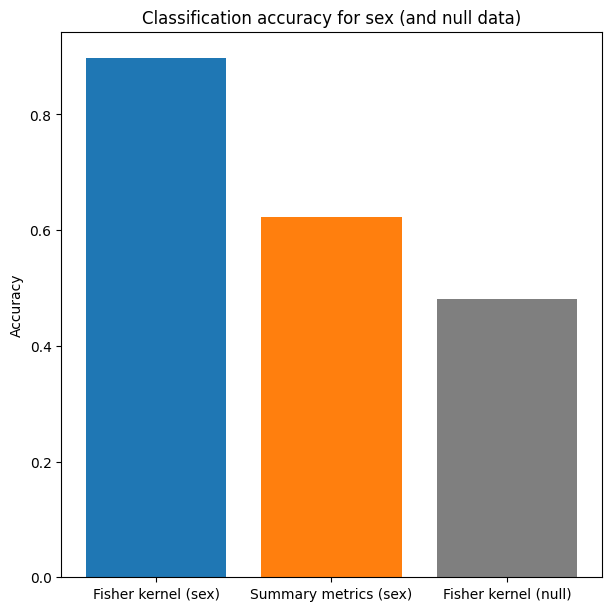

In [91]:
fig, ax = plt.subplots(layout="constrained", figsize=(6, 6))
features = ["Fisher kernel (sex)", "Summary metrics (sex)", "Fisher kernel (null)"]
classif_acc = [classif_FK['acc'], classif_summ['acc'], classif_null['acc']]
bar_colors = ['tab:blue', 'tab:orange', 'tab:grey']
ax.bar(features, classif_acc, color=bar_colors)
ax.set_ylabel('Accuracy')
ax.set_title('Classification accuracy for sex (and null data)')
plt.show()

Plot ROC-curve to look at true vs. false positives. In this case, this helps to understand whether the model is biased towards one class or the other.

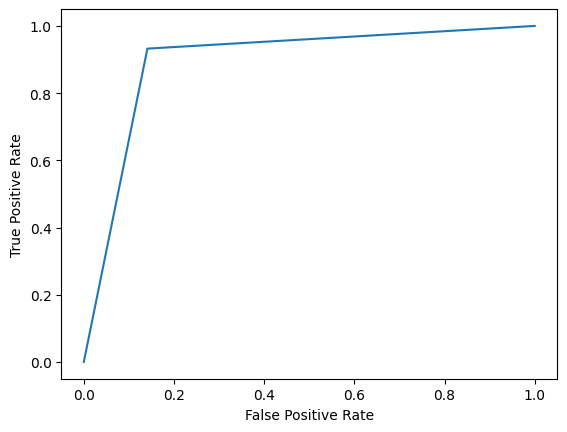

In [167]:
import sklearn.metrics as ms
fpr, tpr, _ = ms.roc_curve(sex, classif_FK['behav_pred'], pos_label=1)
roc_display = ms.RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()

Finally, combine all previous plots into a figure comparing prediction accuracy and classification accuracy using Fisher kernel approach vs. summary metrics approach:

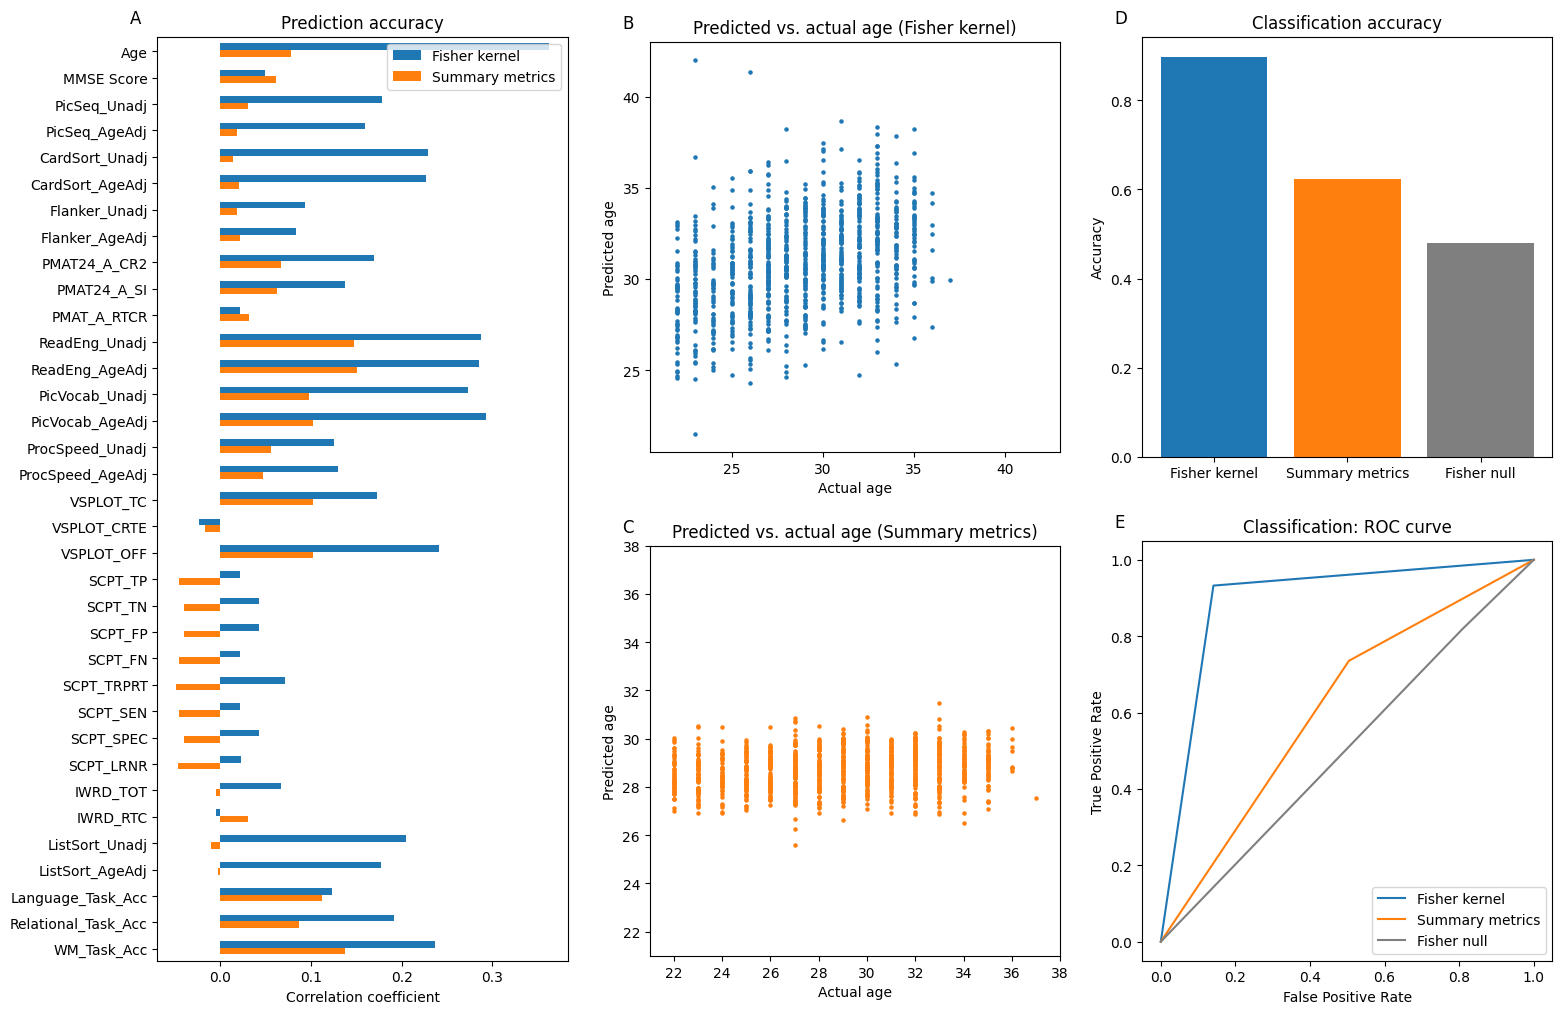

In [176]:
import matplotlib.transforms as mtransforms
import sklearn.metrics as ms
fig, axs = plt.subplot_mosaic([['A', 'B', 'D'], ['A', 'C', 'E']], figsize=(18,12))
for label, ax in axs.items():
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom')

# Prediction accuracy all variables (A)
variables = ("Age", "MMSE Score", "PicSeq_Unadj", "PicSeq_AgeAdj",
             "CardSort_Unadj", "CardSort_AgeAdj", "Flanker_Unadj",
             "Flanker_AgeAdj", "PMAT24_A_CR2", "PMAT24_A_SI", 
             "PMAT_A_RTCR", "ReadEng_Unadj", "ReadEng_AgeAdj",
             "PicVocab_Unadj", "PicVocab_AgeAdj", "ProcSpeed_Unadj",
             "ProcSpeed_AgeAdj", "VSPLOT_TC", "VSPLOT_CRTE", 
             "VSPLOT_OFF", "SCPT_TP", "SCPT_TN", "SCPT_FP", "SCPT_FN",
             "SCPT_TRPRT", "SCPT_SEN", "SCPT_SPEC", "SCPT_LRNR", 
             "IWRD_TOT", "IWRD_RTC", "ListSort_Unadj", "ListSort_AgeAdj",
             "Language_Task_Acc", "Relational_Task_Acc", "WM_Task_Acc")
comp_acc = {
    'Fisher kernel': results_FK,
    'Summary metrics': results_summ
}
acc_df = pd.DataFrame(comp_acc, index=variables)
x = np.arange(behav.shape[1])
width = 0.3
ax1 = acc_df.plot.barh(ax=axs['A'], rot=0, color={"Fisher kernel": "tab:blue", "Summary metrics": "tab:orange"}, align="edge")
ax1.invert_yaxis()
ax1.set_xlabel('Correlation coefficient')
ax1.legend(loc='upper right', ncols=1)
ax1.set_yticks(x + width, variables)
ax1.set_title('Prediction accuracy')

# Scatter plot Age: Fisher kernel
axs['B'].scatter(age, results['behav_predD'], s=5, color='tab:blue')
minval = min((min(age), min(results['behav_predD'])))
maxval = max((max(age), max(results['behav_predD'])))
axs['B'].set_xlim((minval-1),(maxval+1))
axs['B'].set_xlabel('Actual age')
axs['B'].set_ylim((minval-1),(maxval+1))
axs['B'].set_ylabel('Predicted age')
axs['B'].set_aspect('equal', adjustable='box')
axs['B'].set_title('Predicted vs. actual age (Fisher kernel)')

# Scatter plot Age: Summary metrics
axs['C'].scatter(age, results2['behav_predD'], s=5, color='tab:orange')
minval = min((min(age), min(results2['behav_predD'])))
maxval = max((max(age), max(results2['behav_predD'])))
axs['C'].set_xlim((minval-1),(maxval+1))
axs['C'].set_xlabel('Actual age')
axs['C'].set_ylim((minval-1),(maxval+1))
axs['C'].set_ylabel('Predicted age')
axs['C'].set_aspect('equal', adjustable='box')
axs['C'].set_title('Predicted vs. actual age (Summary metrics)')

# Classification accuracy Sex
features = ["Fisher kernel", "Summary metrics", "Fisher null"]
classif_acc = [classif_FK['acc'], classif_summ['acc'], classif_null['acc']]
bar_colors = ['tab:blue', 'tab:orange', 'tab:grey']
axs['D'].bar(features, classif_acc, color=bar_colors)
axs['D'].set_ylabel('Accuracy')
axs['D'].set_title('Classification accuracy')

# ROC plots Classification Sex
fpr_FK, tpr_FK, _ = ms.roc_curve(sex, classif_FK['behav_pred'], pos_label=1)
fpr_summ, tpr_summ, _ = ms.roc_curve(sex, classif_summ['behav_pred'], pos_label=1)
fpr_null, tpr_null, _ = ms.roc_curve(sex, classif_null['behav_pred'], pos_label=1)
ms.RocCurveDisplay(fpr=fpr_FK, tpr=tpr_FK).plot(ax=axs['E'], color='tab:blue')
ms.RocCurveDisplay(fpr=fpr_summ, tpr=tpr_summ).plot(ax=axs['E'], color='tab:orange')
ms.RocCurveDisplay(fpr=fpr_null, tpr=tpr_null).plot(ax=axs['E'], color='tab:grey')
axs['E'].legend((features))
axs['E'].set_title('Classification: ROC curve')

plt.show()